# Continuous Subspace

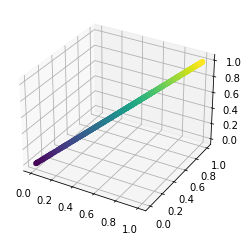

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnf

n = 1000
k = 3
l = 1

z = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)

# class Scale(nn.Module):
#     def __init__(self, factor):
#         super(Scale, self).__init__()
#         self.factor = factor
    
#     def forward(self, x):
#         return x * self.factor



color = z.flatten(1).numpy()[:, 0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z.flatten(1).numpy()[:, 0], z.flatten(1).numpy()[:, 1], z.flatten(1).numpy()[:, 2], c=color)
plt.show()
# plt.scatter(z_def.flatten(1).numpy()[:, 0], z_def.flatten(1).numpy()[:, 1], c=color)

torch.Size([1000, 3, 1])
torch.Size([1000, 3, 1])


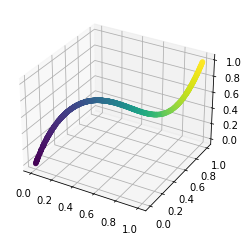

In [6]:
class NormalizeDims(nn.Module):
    def __init__(self, k, l):
        super(NormalizeDims, self).__init__()
        self.k, self.l = k, l
    
    def forward(self, x):
        z = x.reshape(-1, self.k * self.l)
        lims = []
        for i in range(self.k * self.l):
            # lims.append({'min': x[:,i].min(), 'max': x[:,i].max()})
            _min = z[:, i].min()
            _max = z[:, i].max()
            z[:, i] = (z[:, i] - _min) / (_max-_min)

        return z.flatten()

D = 100
deform = nn.Sequential(
        nn.Linear(k * l, D),
        nn.Tanh(),
        nn.Linear(D, k * l),
        nn.Tanh(),
        NormalizeDims(k, l)
    )

with torch.no_grad():
    z_def = deform(z.flatten(1)).reshape(n, k, l)
    t = -pow((2 * (z[:, 0] - 0.5)), 2) + 1
    t = t.unsqueeze(1).repeat(1, 3, 1)
    print(t.shape)
    print(z_def.shape)
    z_def = t * z_def + (1 - t) * z

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z.flatten(1).numpy()[:, 0], z_def.flatten(1).numpy()[:, 1], z_def.flatten(1).numpy()[:, 2], c=color)
plt.show()

1
2


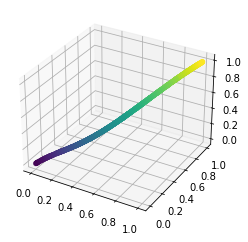

In [4]:
class Deform(nn.Module):
    def __init__(self, k, l, D=100):
        super().__init__()
        self.k, self.l = k, l
        self.deform = nn.Sequential(
            nn.Linear(1, D),
            nn.Tanh(),
            nn.Linear(D, 1),
        )
    
    def forward(self, x):
        xx = x.reshape(-1, self.k * self.l).clone()
        lims = []
        for i in range(1, self.k * self.l):
            print(i)
            xxx = self.deform(xx[:, i].unsqueeze(1)).squeeze()
            _min = xxx.min()
            _max = xxx.max()
            xxx = (xxx - _min) / (_max-_min)
            t = -pow((2 * (xx[:, 0] - 0.5)), 2) + 1
            xx[:, i] = t * xxx + (1 - t) * xx[:, i]

        return xx.flatten()

with torch.no_grad():
    z_def = Deform(k, l)(z.flatten(1)).reshape(n, k, l)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z_def.flatten(1).numpy()[:, 0], z_def.flatten(1).numpy()[:, 1], z_def.flatten(1)[:, 2], c=color)
plt.show()

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1.0000, 0.9985, 0.9951],
        [0.9985, 1.0000, 0.9986],
        [0.9951, 0.9986, 1.0000]])
tensor([[1.0000, 0.9621, 0.8699],
        [0.9621, 1.0000, 0.9637],
        [0.8699, 0.9637, 1.0000]])
tensor([[1.0000, 0.8380, 0.5317],
        [0.8380, 1.0000, 0.8364],
        [0.5317, 0.8364, 1.0000]])
tensor([[1.0000, 0.6400, 0.3147],
        [0.6400, 1.0000, 0.6416],
        [0.3147, 0.6416, 1.0000]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1.0000, 0.9946, 0.9785],
        [0.9946, 1.0000, 0.9946],
        [0.9785, 0.9946, 1.0000]])
tensor([[1.0000, 0.9233, 0.7394],
        [0.9233, 1.0000, 0.9201],
        [0.7394, 0.9201, 1.0000]])
tensor([[1.0000, 0.7369, 0.4226],
        [0.7369, 1.0000, 0.7308],
        [0.4226, 0.7308, 1.0000]])
tensor([[1.0000, 0.5577, 0.2658],
        [0.5577, 1.0000, 0.5668],
        [0.2658, 0.5668, 1.0000]])
tensor([[1., 1., 1.],
        [1., 1., 1.]

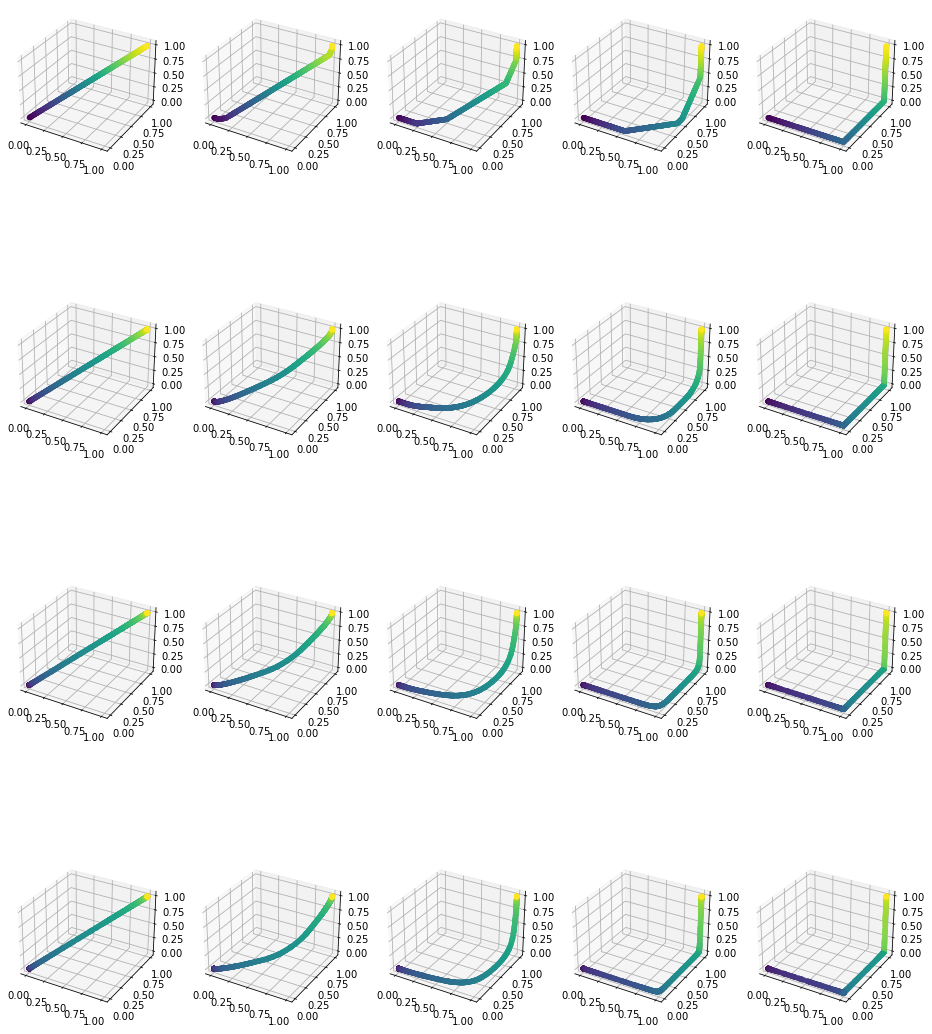

In [7]:
from numpy import linspace


class DeformSmooth(nn.Module):
    def __init__(self, order: int=4, a: float=0):
        super(DeformSmooth, self).__init__()
        assert order > 0, 'order must be an integer > 0'
        assert 0 <= a and a <= 1, 'a must be from [0, 1]'
        self.a = pow(a, 2)

        if order % 2:
            half_step = lambda x: torch.minimum(torch.maximum(torch.pow(2 * x, order), torch.zeros_like(x)), torch.ones_like(x)) / 2
        else:
            half_step = lambda x: torch.pow(torch.minimum(torch.maximum(2 * x, torch.zeros_like(x)), torch.ones_like(x)), order) / 2
        
        self.step = lambda x: half_step(x) - half_step(1 - x) + 0.5
    
    def forward(self, x):
        out = torch.zeros_like(x)
        n = x.shape[1]

        for d in range(n):
            out[:, d] = self.step(((n - 1) * self.a + 1) * x[:, d] - d * self.a)
        
        return out

fig = plt.figure(figsize=(16, 20))

for i, order in enumerate(range(1, 5)):
    for j, a in enumerate(linspace(0, 1, 5)):
        with torch.no_grad():
            z_def = DeformSmooth(order, a)(z.flatten(1))
        ax = fig.add_subplot(4, 5, i*5+j+1, projection='3d')
        ax.scatter(z_def[:, 0], z_def[:, 1], z_def[:, 2], c=color)
        pearson = torch.corrcoef(z_def.t())
        print(pearson)

plt.show()

# Non-Continuous Subspace

In [52]:
# import matplotlib.pyplot as plt
import torch
# import torch.nn as nn
# import torch.nn.functional as nnf

n = 1000
k = 3
l = 2

def correlate_nd(t: torch.Tensor) -> torch.Tensor:
    """Estimate the n-d correlation coefficient matrix of the variables given by the input matrix `t`, 
    where rows are the variables and columns are the observations."""
    t = t.flatten(2)  # dim 0 are the variables, dim 1 are the observations, everything else are the variables

    def corr2_coeff(A, B):
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1).unsqueeze(1)
        B_mB = B - B.mean(1).unsqueeze(1)

        # Sum of squares across rows
        ssA = (A_mA**2).sum(1)
        ssB = (B_mB**2).sum(1)

        # Finally get corr coeff
        return torch.tensordot(A_mA, B_mB.t(), dims=([1, 0], [0, 1])) / torch.sqrt(torch.tensordot(ssA.unsqueeze(1),ssB.unsqueeze(0), dims=([1, 0], [0, 1])))

    out = torch.zeros([t.shape[1]]*2)
    for i in range(t.shape[1]):
        for j in range(t.shape[1]):
            out[i, j] = corr2_coeff(t[:,i,:], t[:,j,:])
    
    return out / out[0,0]

# TODO check why normalization is needed, probably just use corr2d from scipy

z_diag = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)
print(f'Pearson correlation matrix\n{correlate_nd(z_diag).numpy()}')

Pearson correlation matrix
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [53]:
z_rand = torch.rand(n, k, l)
print(f'Pearson correlation matrix\n{correlate_nd(z_rand).numpy()}')

Pearson correlation matrix
[[ 1.          0.03461039  0.07158691]
 [ 0.03461039  1.0311011  -0.04265764]
 [ 0.07158691 -0.04265764  1.0228437 ]]
